# Project: Wrangling and Analyze Data

## Data Gathering

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
from datetime import datetime
import time

pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')
sns.set(style="whitegrid")
archive = pd.read_csv('twitter-archive-enhanced.csv')
print("Checking for tweet_json.txt file...")
if not os.path.exists('tweet_json.txt'):
    print("ERROR: tweet_json.txt file not found!")
    print("Download it from: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_twitter-archive-enhanced/twitter-archive-enhanced.csv")
else:
    print("tweet_json.txt found! Proceeding...")

Checking for tweet_json.txt file...
tweet_json.txt found! Proceeding...


In [2]:
# Import requests
import requests
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open('image-predictions.tsv', 'wb') as file:
    file.write(response.content)
    
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

image_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
image_file = "image-predictions.csv"

if not os.path.exists(image_file):
    print(f"Downloading {image_file}...")
    response = requests.get(image_url)
    
    df = pd.read_csv(pd.compat.StringIO(response.text), sep='\t')
    df.to_csv(image_file, index=False)
    print(f"Saved as {image_file} ({os.path.getsize(image_file)/1024:.1f} KB)")
else:
    print(f"{image_file} already exists")

image-predictions.csv already exists


In [3]:
import os
url = "https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt"
save_name = "tweet_json.txt"

print("Downloading official Twitter data...")
response = requests.get(url)
with open(save_name, "wb") as f:
    f.write(response.content)

# Verify
size_mb = os.path.getsize(save_name) / (1024 * 1024)
print(f"Download complete! Size: {size_mb:.1f} MB")

# Count lines
with open(save_name, "r", encoding="utf-8") as f:
    lines = sum(1 for _ in f)
print(f"Line count: {lines}")
size_mb = os.path.getsize('tweet_json.txt') / (1024 * 1024)
print(f"Size check: {size_mb:.1f} MB (should be ~52.5)")

with open('tweet_json.txt', 'r', encoding='utf-8') as f:
    first_line = f.readline().strip()
    print(f"First 100 chars: {first_line[:100]}...")

Download complete! Size: 10.1 MB
Line count: 2354
Size check: 10.1 MB (should be ~52.5)
First 100 chars: {"created_at": "Tue Aug 01 16:23:56 +0000 2017", "id": 892420643555336193, "id_str": "89242064355533...


In [4]:
file_path = 'tweet_json.txt'  # MUST be exactly this filename
if not os.path.exists(file_path):
    print(f"CRITICAL ERROR: File '{file_path}' not found in:")
    print(os.getcwd())
    print("\nFiles in directory:")
    print(os.listdir())
    print("Not working!")
    raise SystemExit("Execution stopped - missing required file")

In [5]:
#Import Tweepy
import tweepy
tweet_data = []
valid_count = 0
problem_lines = 0

print("Processing Twitter data...")
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        if not line:
            continue
            
        try:
            tweet = json.loads(line)
            tweet_id = str(tweet['id']) 
            retweet_count = tweet.get('retweet_count', 0)
            favorite_count = tweet.get('favorite_count', 0)
            
            tweet_data.append({
                'tweet_id': tweet_id,
                'retweet_count': retweet_count,
                'favorite_count': favorite_count
            })
            valid_count += 1
        except (json.JSONDecodeError, KeyError) as e:
            problem_lines += 1
            continue

api_data = pd.DataFrame(tweet_data)

print("\n" + "="*50)
print("TWITTER API DATA PROCESSING REPORT")
print("="*50)
print(f"File processed: {file_path}")
print(f"Size: {os.path.getsize(file_path)/ (1024*1024):.1f} MB")
print(f"Valid tweets processed: {valid_count}")
print(f"Problematic lines skipped: {problem_lines}")
print(f"Missing values: {api_data.isnull().sum().sum()}")

if valid_count > 0:
    print("\nFirst 3 tweets:")
    print(api_data.head(3))
    print("\nSummary statistics:")
    print(api_data.describe())

    if 'archive_df' in globals():
        try:
            archive_ids = set(archive_df['tweet_id'].astype(str))
            api_ids = set(api_data['tweet_id'])
            missing = archive_ids - api_ids
            print(f"\nTweets in archive missing from API data: {len(missing)}")
            if len(missing) > 0:
                print("Example missing IDs:", list(missing)[:3])
        except Exception as e:
            print(f"\nArchive comparison error: {e}")
else:
    print("\n Not working!")

Processing Twitter data...

TWITTER API DATA PROCESSING REPORT
File processed: tweet_json.txt
Size: 10.1 MB
Valid tweets processed: 2354
Problematic lines skipped: 0
Missing values: 0

First 3 tweets:
   favorite_count  retweet_count            tweet_id
0           39467           8853  892420643555336193
1           33819           6514  892177421306343426
2           25461           4328  891815181378084864

Summary statistics:
       favorite_count  retweet_count
count     2354.000000    2354.000000
mean      8080.968564    3164.797366
std      11814.771334    5284.770364
min          0.000000       0.000000
25%       1415.000000     624.500000
50%       3603.500000    1473.500000
75%      10122.250000    3652.000000
max     132810.000000   79515.000000


## Assessing Data

In [6]:
archive_df = pd.read_csv('twitter-archive-enhanced.csv')
image_preds_df = pd.read_csv('image-predictions.csv')

def comprehensive_assessment(df, name):
    print(f"\n{'='*60}")
    print(f"ASSESSING DATASET: {name.upper()}")
    print(f"{'='*60}")
    
    # Visual assessment
    print("\nVISUAL ASSESSMENT:")
    print("\nFirst 3 rows:")
    display(df.head(3))
    print("\nRandom 3 rows:")
    display(df.sample(3, random_state=1))
    print("\nLast 3 rows:")
    display(df.tail(3))
    
    # Programmatic assessment
    print("\nPROGRAMMATIC ASSESSMENT:")
    print("\n1. Data types and memory usage (info()):")
    print(df.info())
    
    print("\n2. Statistical summary (describe()):")
    display(df.describe(include='all'))
    
    print("\n3. Missing values (isnull().sum()):")
    print(df.isnull().sum())
    
    print("\n4. Duplicate rows (duplicated().sum()):")
    print(f"Total duplicates: {df.duplicated().sum()}")
    
    print("\n5. Unique values (nunique()):")
    print(df.nunique())
        
    for i, col in enumerate(df.columns[:2]):
        print(f"\n6.{i+1} Value counts for '{col}':")
        print(df[col].value_counts().head(5))

print("\n\nDATA ASSESSMENT REPORT FOR ALL DATASETS")
comprehensive_assessment(archive_df, "Twitter Archive")
comprehensive_assessment(image_preds_df, "Image Predictions")
comprehensive_assessment(api_data, "Twitter API Data")



DATA ASSESSMENT REPORT FOR ALL DATASETS

ASSESSING DATASET: TWITTER ARCHIVE

VISUAL ASSESSMENT:

First 3 rows:


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None



Random 3 rows:


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1204,716080869887381504,NaN,NaN,2016-04-02 01:52:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super majestic doggo and a sunset 11/...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716080869...,11,10,None,doggo,None,None,None
50,882627270321602560,NaN,NaN,2017-07-05 15:48:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stanley. He has his first swim lesson ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/882627270...,13,10,Stanley,None,None,None,None
812,771136648247640064,NaN,NaN,2016-09-01 00:04:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Dixie. She wants to be a ship captain....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/771136648...,11,10,Dixie,None,None,None,None



Last 3 rows:


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None



PROGRAMMATIC ASSESSMENT:

1. Data types and memory usage (info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo          

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
count,2.356000e+03,7.800000e+01,7.800000e+01,2356,2356,2356,1.810000e+02,1.810000e+02,181,2297,2356.000000,2356.000000,2356,2356,2356,2356,2356
unique,NaN,NaN,NaN,2356,4,2356,NaN,NaN,181,2218,NaN,NaN,957,2,2,2,2
top,NaN,NaN,NaN,2015-11-18 16:12:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Bruiser &amp; Charlie. They are the best ...,NaN,NaN,2015-11-16 04:02:55 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",NaN,NaN,None,None,None,None,None
freq,NaN,NaN,NaN,1,2221,1,NaN,NaN,1,2,NaN,NaN,745,2259,2346,2099,2326
mean,7.427716e+17,7.455079e+17,2.014171e+16,NaN,NaN,NaN,7.720400e+17,1.241698e+16,NaN,NaN,13.126486,10.455433,NaN,NaN,NaN,NaN,NaN
std,6.856705e+16,7.582492e+16,1.252797e+17,NaN,NaN,NaN,6.236928e+16,9.599254e+16,NaN,NaN,45.876648,6.745237,NaN,NaN,NaN,NaN,NaN
min,6.660209e+17,6.658147e+17,1.185634e+07,NaN,NaN,NaN,6.661041e+17,7.832140e+05,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,6.783989e+17,6.757419e+17,3.086374e+08,NaN,NaN,NaN,7.186315e+17,4.196984e+09,NaN,NaN,10.000000,10.000000,NaN,NaN,NaN,NaN,NaN
50%,7.196279e+17,7.038708e+17,4.196984e+09,NaN,NaN,NaN,7.804657e+17,4.196984e+09,NaN,NaN,11.000000,10.000000,NaN,NaN,NaN,NaN,NaN
75%,7.993373e+17,8.257804e+17,4.196984e+09,NaN,NaN,NaN,8.203146e+17,4.196984e+09,NaN,NaN,12.000000,10.000000,NaN,NaN,NaN,NaN,NaN



3. Missing values (isnull().sum()):
tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

4. Duplicate rows (duplicated().sum()):
Total duplicates: 0

5. Unique values (nunique()):
tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_u

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True



Random 3 rows:


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
724,686034024800862208,https://pbs.twimg.com/media/CYVIToGWQAAEZ_y.jpg,1,Great_Dane,0.236920,True,Irish_wolfhound,0.117608,True,Greater_Swiss_Mountain_dog,0.103900,True
348,672481316919734272,https://pbs.twimg.com/media/CVUiMUeW4AEQgkU.jpg,1,Border_collie,0.599454,True,collie,0.106227,True,Shetland_sheepdog,0.094465,True
102,667801013445750784,https://pbs.twimg.com/media/CUSBemVUEAAn-6V.jpg,1,flat-coated_retriever,0.508392,True,Chesapeake_Bay_retriever,0.262239,True,curly-coated_retriever,0.048920,True



Last 3 rows:


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False



PROGRAMMATIC ASSESSMENT:

1. Data types and memory usage (info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB
None

2. Statistical summary (describe()):


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
count,2.075000e+03,2075,2075.000000,2075,2075.000000,2075,2075,2.075000e+03,2075,2075,2.075000e+03,2075
unique,NaN,2009,NaN,378,NaN,2,405,NaN,2,408,NaN,2
top,NaN,https://pbs.twimg.com/media/C2kzTGxWEAEOpPL.jpg,NaN,golden_retriever,NaN,True,Labrador_retriever,NaN,True,Labrador_retriever,NaN,True
freq,NaN,2,NaN,150,NaN,1532,104,NaN,1553,79,NaN,1499
mean,7.384514e+17,NaN,1.203855,NaN,0.594548,NaN,NaN,1.345886e-01,NaN,NaN,6.032417e-02,NaN
std,6.785203e+16,NaN,0.561875,NaN,0.271174,NaN,NaN,1.006657e-01,NaN,NaN,5.090593e-02,NaN
min,6.660209e+17,NaN,1.000000,NaN,0.044333,NaN,NaN,1.011300e-08,NaN,NaN,1.740170e-10,NaN
25%,6.764835e+17,NaN,1.000000,NaN,0.364412,NaN,NaN,5.388625e-02,NaN,NaN,1.622240e-02,NaN
50%,7.119988e+17,NaN,1.000000,NaN,0.588230,NaN,NaN,1.181810e-01,NaN,NaN,4.944380e-02,NaN
75%,7.932034e+17,NaN,1.000000,NaN,0.843855,NaN,NaN,1.955655e-01,NaN,NaN,9.180755e-02,NaN



3. Missing values (isnull().sum()):
tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

4. Duplicate rows (duplicated().sum()):
Total duplicates: 0

5. Unique values (nunique()):
tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

6.1 Value counts for 'tweet_id':
685532292383666176    1
826598365270007810    1
692158366030913536    1
714606013974974464    1
715696743237730304    1
Name: tweet_id, dtype: int64

6.2 Value counts for 'jpg_url':
https://pbs.twimg.com/media/C2kzTGxWEAEOpPL.jpg    2
https://pbs.twimg.com/media/C2oRbOuWEAAbVSl.jpg    2
https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg    2
https://pbs.twimg.com/media/CcG07BYW0AErrC9.jpg    2
https://pbs.twimg.com/media/C4KHj-nWQAA3poV.j

,favorite_count,retweet_count,tweet_id
0,39467,8853,892420643555336193
1,33819,6514,892177421306343426
2,25461,4328,891815181378084864



Random 3 rows:


,favorite_count,retweet_count,tweet_id
1593,2398,776,686358356425093120
65,107956,45849,879415818425184262
1863,35178,18963,675354435921575936



Last 3 rows:


,favorite_count,retweet_count,tweet_id
2351,128,47,666033412701032449
2352,132,48,666029285002620928
2353,2535,532,666020888022790149



PROGRAMMATIC ASSESSMENT:

1. Data types and memory usage (info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null object
dtypes: int64(2), object(1)
memory usage: 55.2+ KB
None

2. Statistical summary (describe()):


,favorite_count,retweet_count,tweet_id
count,2354.000000,2354.000000,2354
unique,NaN,NaN,2354
top,NaN,NaN,672964561327235073
freq,NaN,NaN,1
mean,8080.968564,3164.797366,NaN
std,11814.771334,5284.770364,NaN
min,0.000000,0.000000,NaN
25%,1415.000000,624.500000,NaN
50%,3603.500000,1473.500000,NaN
75%,10122.250000,3652.000000,NaN



3. Missing values (isnull().sum()):
favorite_count    0
retweet_count     0
tweet_id          0
dtype: int64

4. Duplicate rows (duplicated().sum()):
Total duplicates: 0

5. Unique values (nunique()):
favorite_count    2007
retweet_count     1724
tweet_id          2354
dtype: int64

6.1 Value counts for 'favorite_count':
0       179
610       3
345       3
2918      3
1691      3
Name: favorite_count, dtype: int64

6.2 Value counts for 'retweet_count':
1972    5
3652    5
83      5
146     4
61      4
Name: retweet_count, dtype: int64


In [7]:
print("\n" + "="*50)
print("Step 2: Assessing Data")
print("="*50)

#visual Assessing
print("\nVisual Assessment:")
print("Twitter Archive (First 5 rows):")
print(archive.head())

print("\nImage Predictions (First 5 rows):")
print(image_predictions.head())

print("\nAPI Data (First 5 rows):")
print(api_data.head())

#programatic Assessing
# Twitter Archive Assessment
print("\n" + "-"*50)
print("Programmatic Assessment: Twitter Archive")
print("-"*50)

print("\nBasic Information:")
archive.info()

print("\nMissing Values:")
print(archive.isnull().sum())

print("\nValue Counts - Rating Denominators:")
print(archive['rating_denominator'].value_counts())

print("\nValue Counts - Dog Stages:")
print("doggo:", archive['doggo'].value_counts())
print("pupper:", archive['pupper'].value_counts())
print("puppo:", archive['puppo'].value_counts())
print("floofer:", archive['floofer'].value_counts())
print("\nTimestamp Range:")
print("Min:", archive['timestamp'].min())
print("Max:", archive['timestamp'].max())

print("\nDuplicate Tweets:")
print("Duplicates:", archive['tweet_id'].duplicated().sum())

print("\nRating Numerator Summary:")
print(archive['rating_numerator'].describe())

print("\nSource Value Counts:")
print(archive['source'].value_counts())


Step 2: Assessing Data

Visual Assessment:
Twitter Archive (First 5 rows):
             tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   
3  891689557279858688                    NaN                  NaN   
4  891327558926688256                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   
3  2017-07-30 15:58:51 +0000   
4  2017-07-29 16:00:24 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/downl

In [8]:
# Image Predictions Assessment
print("\n" + "-"*50)
print("Programmatic Assessment: Image Predictions")
print("-"*50)

print("\nBasic Information:")
print(image_predictions.info())
print("\nMissing Values:")
print(image_predictions.isnull().sum())

print("\nImage Prediction Confidence:")
print(image_predictions[['p1_conf', 'p2_conf', 'p3_conf']].describe())

print("\nDog Prediction Flags:")
print("p1_dog:", image_predictions['p1_dog'].value_counts())
print("p2_dog:", image_predictions['p2_dog'].value_counts())
print("p3_dog:", image_predictions['p3_dog'].value_counts())

print("\nTop Predictions:")
print("p1:", image_predictions['p1'].value_counts().head(5))


--------------------------------------------------
Programmatic Assessment: Image Predictions
--------------------------------------------------

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB
None

Missing Values:
tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

Image Prediction Confidence:
           p1_conf       p2_co

In [9]:
print("\n" + "-"*50)
print("Programmatic Assessment: API Data")
print("-"*50)

if api_data.empty:
    print("\nWARNING: API Data is empty!")
else:
    print("\nBasic Information:")
    api_data.info()

    print("\nMissing Values:")
    print(api_data.isnull().sum())

    if 'retweet_count' in api_data.columns and 'favorite_count' in api_data.columns:
        print("\nEngagement Statistics:")
        print(api_data[['retweet_count', 'favorite_count']].describe())
    else:
        print("\nEngagement Statistics: Required columns missing")
        print("Available columns:", api_data.columns.tolist())
    print("\nDuplicate Tweets:")
    if 'tweet_id' in api_data.columns:
        print("Duplicates:", api_data['tweet_id'].duplicated().sum())
    else:
        print("tweet_id column missing - cannot check duplicates")


--------------------------------------------------
Programmatic Assessment: API Data
--------------------------------------------------

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null object
dtypes: int64(2), object(1)
memory usage: 55.2+ KB

Missing Values:
favorite_count    0
retweet_count     0
tweet_id          0
dtype: int64

Engagement Statistics:
       retweet_count  favorite_count
count    2354.000000     2354.000000
mean     3164.797366     8080.968564
std      5284.770364    11814.771334
min         0.000000        0.000000
25%       624.500000     1415.000000
50%      1473.500000     3603.500000
75%      3652.000000    10122.250000
max     79515.000000   132810.000000

Duplicate Tweets:
Duplicates: 0


In [10]:
with open('assessment_report.txt', 'w') as f:
    f.write("WeRateDogs Data Assessment Report\n")
    f.write("="*40 + "\n\n")
    f.write("Quality Issues Identified:\n")
    f.write("1. Missing values in expanded_urls\n")
    f.write("2. Incorrect dog stages (multiple values in same row)\n")
    f.write("3. Timestamp as string\n")
    f.write("4. Rating numerator outliers\n")
    f.write("5. Rating denominator outliers\n")
    f.write("6. Source column HTML tags\n")
    f.write("7. Retweets included\n")
    f.write("8. Image predictions contain non-dog results\n")
    f.write("9. Some tweets have no image predictions\n")
    f.write("10. Inconsistent capitalization in dog breeds\n\n")
    
    f.write("Tidiness Issues Identified:\n")
    f.write("1. Dog stages in four separate columns\n")
    f.write("2. Three separate datasets\n")
    f.write("3. Image predictions in wide format\n\n")
    f.write("Cleaning Plan:\n")
    f.write("- Remove retweets and non-image tweets\n")
    f.write("- Combine dog stage columns\n")
    f.write("- Extract correct ratings from text\n")
    f.write("- Convert timestamp to datetime\n")
    f.write("- Clean source column\n")
    f.write("- Filter only dog predictions\n")
    f.write("- Merge all datasets into one\n")
    f.write("- Standardize breed names\n")
print("\nAssessment complete! Report saved to 'assessment_report.txt'")


Assessment complete! Report saved to 'assessment_report.txt'


### Quality issues

1. Missing values in expanded_urls
2. Incorrect dog stages (multiple values in same row)
3. Timestamp as string
4. Rating numerator outliers
5. Rating denominator outliers
6. Source column HTML tags
7. Retweets included
8. Image predictions contain non-dog results

### Tidiness issues
1. Dog stages in four separate columns
2. Three separate datasets

## Cleaning Data

In [11]:
archive_clean = archive.copy()
predictions_clean = image_predictions.copy()
api_clean = api_data.copy()
print("Start cleaning...")

Start cleaning...


### Issue #1:

#### Define: Missing values in expanded_urls

#### Code

In [12]:
print("\nFixing quality issue 1: Removing tweets without expanded URLs...")

archive_clean = archive_clean.dropna(subset=['expanded_urls'])


Fixing quality issue 1: Removing tweets without expanded URLs...


#### Test

In [13]:
print("Testing Issue #1:")
print(f"- Rows before: {len(archive)}")
print(f"- Rows after: {len(archive_clean)}")
print(f"- Missing values in expanded_urls: {archive_clean['expanded_urls'].isnull().sum()}")


Testing Issue #1:
- Rows before: 2356
- Rows after: 2297
- Missing values in expanded_urls: 0


### Issue #2:

#### Define: Incorrect dog stages (multiple values)

#### Code

In [14]:
print("\nFixing quality issue 2: Standardizing dog stages...")

def combine_dog_stages(row):
    stages = []
    if row['doggo'] == 'doggo': stages.append('doggo')
    if row['pupper'] == 'pupper': stages.append('pupper')
    if row['puppo'] == 'puppo': stages.append('puppo')
    if row['floofer'] == 'floofer': stages.append('floofer')
    return ', '.join(stages) if stages else None

archive_clean['dog_stage'] = archive_clean.apply(combine_dog_stages, axis=1)


Fixing quality issue 2: Standardizing dog stages...


#### Test

In [15]:
print("Testing Issue #2:")
print("Sample dog stage combinations before cleaning:")
print(archive[['doggo', 'pupper', 'puppo', 'floofer']].head(10))
print("\nDog stage after combining:")
print(archive_clean['dog_stage'].value_counts(dropna=False).head(10))

Testing Issue #2:
Sample dog stage combinations before cleaning:
   doggo pupper puppo floofer
0   None   None  None    None
1   None   None  None    None
2   None   None  None    None
3   None   None  None    None
4   None   None  None    None
5   None   None  None    None
6   None   None  None    None
7   None   None  None    None
8   None   None  None    None
9  doggo   None  None    None

Dog stage after combining:
NaN               1923
pupper             243
doggo               80
puppo               28
doggo, pupper       12
floofer              9
doggo, floofer       1
doggo, puppo         1
Name: dog_stage, dtype: int64


### Issue #3:

#### Define: Timestamp as string

#### Code

In [16]:
print("\nFixing quality issue 3: Converting timestamp to datetime...")

archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])


Fixing quality issue 3: Converting timestamp to datetime...


#### Test

In [17]:
print("Testing Issue #3:")
print(f"- Data type before: {type(archive['timestamp'].iloc[0])}")
print(f"- Data type after: {type(archive_clean['timestamp'].iloc[0])}")

Testing Issue #3:
- Data type before: <class 'str'>
- Data type after: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


### Issue #4:

#### Define: Rating numerator outliers

#### Code

In [18]:
print("\nFixing quality issue 4: Correcting rating numerators...")

def extract_numerator(text):
    match = re.search(r'(\d+\.?\d*)\s*\/\s*10', text, re.IGNORECASE)
    if match:
        numerator = float(match.group(1))
        return min(numerator, 20)
    return np.nan

archive_clean['rating_numerator'] = archive_clean['text'].apply(extract_numerator)


Fixing quality issue 4: Correcting rating numerators...


#### Test

In [19]:
print("Testing Issue #4:")
print("Rating numerators before cleaning:")
print(archive['rating_numerator'].value_counts().sort_index().tail(10))
print("\nRating numerators after cleaning:")
print(archive_clean['rating_numerator'].value_counts().sort_index().tail(10))

Testing Issue #4:
Rating numerators before cleaning:
121     1
143     1
144     1
165     1
182     1
204     1
420     2
666     1
960     1
1776    1
Name: rating_numerator, dtype: int64

Rating numerators after cleaning:
10.00    456
11.00    456
11.26      1
11.27      1
12.00    547
13.00    340
13.50      1
14.00     52
15.00      1
20.00      2
Name: rating_numerator, dtype: int64


### Issue #5:

#### Define: Rating denominator outliers

#### Code

In [20]:
print("\nFixing quality issue 5: Standardizing denominators to 10...")

archive_clean['rating_denominator'] = 10


Fixing quality issue 5: Standardizing denominators to 10...


#### Test

In [21]:
print("Testing Issue #5:")
print("Rating denominators before cleaning:")
print(archive['rating_denominator'].value_counts().head())
print("\nRating denominators after cleaning:")
print(archive_clean['rating_denominator'].value_counts())

Testing Issue #5:
Rating denominators before cleaning:
10    2333
11       3
50       3
80       2
20       2
Name: rating_denominator, dtype: int64

Rating denominators after cleaning:
10    2297
Name: rating_denominator, dtype: int64


### Issue #6:

#### Define: Source column HTML tags

#### Code

In [22]:
print("\nFixing quality issue 6: Cleaning source column...")

archive_clean['source'] = archive_clean['source'].str.extract(r'>(.*?)<')


Fixing quality issue 6: Cleaning source column...


#### Test

In [23]:
print("Testing Issue #6:")
print("Source values before cleaning:")
print(archive['source'].head(2))
print("\nSource values after cleaning:")
print(archive_clean['source'].head(2))

Testing Issue #6:
Source values before cleaning:
0    <a href="http://twitter.com/download/iphone" r...
1    <a href="http://twitter.com/download/iphone" r...
Name: source, dtype: object

Source values after cleaning:
0    Twitter for iPhone
1    Twitter for iPhone
Name: source, dtype: object


### Issue #7:

#### Define: Retweets included

#### Code

In [24]:
print("\nFixing quality issue 7: Removing retweets...")

archive_clean = archive_clean[archive_clean['retweeted_status_id'].isna()]


Fixing quality issue 7: Removing retweets...


#### Test

In [25]:
print("Testing Issue #7:")
print(f"- Rows before: {len(archive)}")
print(f"- Rows after: {len(archive_clean)}")
print(f"- Retweets remaining: {archive_clean['retweeted_status_id'].notna().sum()}")

Testing Issue #7:
- Rows before: 2356
- Rows after: 2117
- Retweets remaining: 0


### Issue #8:

#### Define: Image predictions contain non-dog results

#### Code

In [26]:
print("\nFixing quality issue 8: Filtering to only dog predictions...")

predictions_clean = predictions_clean[
    (predictions_clean['p1_dog'] == True) | 
    (predictions_clean['p2_dog'] == True) | 
    (predictions_clean['p3_dog'] == True)
]


Fixing quality issue 8: Filtering to only dog predictions...


#### Test

In [27]:
print("Testing Issue #8:")
print("Non-dog predictions before cleaning:")
print(f"- Total predictions: {len(image_predictions)}")
print(f"- Non-dog predictions: {len(image_predictions) - image_predictions[['p1_dog', 'p2_dog', 'p3_dog']].any(axis=1).sum()}")
print("\nAfter cleaning:")
print(f"- Total predictions: {len(predictions_clean)}")
print(f"- Non-dog predictions: {len(predictions_clean) - predictions_clean[['p1_dog', 'p2_dog', 'p3_dog']].any(axis=1).sum()}")

Testing Issue #8:
Non-dog predictions before cleaning:
- Total predictions: 2075
- Non-dog predictions: 324

After cleaning:
- Total predictions: 1751
- Non-dog predictions: 0


### Issue #9: 

#### Define: Dog stages in four separate columns

#### Code

In [28]:
print("\nFixing tidiness issue 1: Removing separate dog stage columns...")

archive_clean = archive_clean.drop(columns=['doggo', 'pupper', 'puppo', 'floofer'])


Fixing tidiness issue 1: Removing separate dog stage columns...


#### Test

In [29]:
print("Testing Tidiness Issue #1:")
print("Columns before:")
print(archive.columns.tolist())
print("\nColumns after:")
print(archive_clean.columns.tolist())

Testing Tidiness Issue #1:
Columns before:
['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']

Columns after:
['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'dog_stage']


### Issue #10:

#### Define: Three separate datasets

#### Code

In [30]:
print("\nFixing tidiness issue 2: Merging datasets into one master table...")

for df in [archive_clean, predictions_clean, api_clean]:
    df['tweet_id'] = df['tweet_id'].astype(str)

merged = pd.merge(archive_clean, predictions_clean, on='tweet_id', how='inner')
df_clean = pd.merge(merged, api_clean, on='tweet_id', how='left')


Fixing tidiness issue 2: Merging datasets into one master table...


#### Test

In [31]:
print("Testing Tidiness Issue #2:")
print(f"- Merged dataset shape: {df_clean.shape}")
print(f"- Columns: {df_clean.columns.tolist()}")
print(f"- Columns in archive: {len(archive_clean.columns)}")
print(f"- Columns in predictions: {len(predictions_clean.columns)}")
print(f"- Columns in API: {len(api_clean.columns)}")
print(f"- Columns in merged: {len(df_clean.columns)}")
print(f"- Rows in merged: {len(df_clean)}")

Testing Tidiness Issue #2:
- Merged dataset shape: (1686, 27)
- Columns: ['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'dog_stage', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'favorite_count', 'retweet_count']
- Columns in archive: 14
- Columns in predictions: 12
- Columns in API: 3
- Columns in merged: 27
- Rows in merged: 1686


In [32]:
print("\nPerforming final cleaning steps...")

# Standardize dog stage
df_clean['dog_stage'] = df_clean['dog_stage'].str.split(',').str[0].fillna('unknown')

# Standardize breed names
df_clean['p1'] = df_clean['p1'].str.title()
df_clean['p2'] = df_clean['p2'].str.title()
df_clean['p3'] = df_clean['p3'].str.title()

# Clean up unnecessary columns
cols_to_drop = [
    'in_reply_to_status_id', 'in_reply_to_user_id', 
    'retweeted_status_id', 'retweeted_status_user_id',
    'retweeted_status_timestamp', 'jpg_url', 'img_num'
]
df_clean = df_clean.drop(columns=cols_to_drop)


Performing final cleaning steps...


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [33]:
df_clean.to_csv('twitter_archive_master.csv', index=False)
print("\nCleaned data saved to 'twitter_archive_master.csv'")

# Final cleaning verification
print("\nFinal cleaning verification:")
print("- Original archive rows: {}".format(len(archive)))
print("- Cleaned master rows: {}".format(len(df_clean)))
print("- Columns reduced from {} to {}".format(
    len(archive.columns) + len(image_predictions.columns) + len(api_data.columns),
    len(df_clean.columns)
))
# Verification step
print("\nMaster dataset saved successfully!")
print(f"- File name: twitter_archive_master.csv")
print(f"- Rows saved: {len(df_clean)}")
print(f"- Columns saved: {len(df_clean.columns)}")
print("\nFirst 3 rows preview:")
print(df_clean.head(3))


Cleaned data saved to 'twitter_archive_master.csv'

Final cleaning verification:
- Original archive rows: 2356
- Cleaned master rows: 1686
- Columns reduced from 32 to 20

Master dataset saved successfully!
- File name: twitter_archive_master.csv
- Rows saved: 1686
- Columns saved: 20

First 3 rows preview:
             tweet_id           timestamp              source  \
0  892177421306343426 2017-08-01 00:17:27  Twitter for iPhone   
1  891815181378084864 2017-07-31 00:18:03  Twitter for iPhone   
2  891689557279858688 2017-07-30 15:58:51  Twitter for iPhone   

                                                text  \
0  This is Tilly. She's just checking pup on you....   
1  This is Archie. He is a rare Norwegian Pouncin...   
2  This is Darla. She commenced a snooze mid meal...   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892177421...              13.0   
1  https://twitter.com/dog_rates/status/891815181...    

## Analyzing and Visualizing Data

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
df = pd.read_csv('twitter_archive_master.csv')
plt.style.use('fivethirtyeight')
sns.set_palette("pastel")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16

### Insights:
1. TOP DOG BREEDS

2. RATING DISTRIBUTION

3. ENGAGEMENT BY DOG STAGE

In [36]:
top_breeds = df['p1'].value_counts().head(5)
print("\nINSIGHT 1: TOP 5 DOG BREEDS")
print("============================")
print(top_breeds)


INSIGHT 1: TOP 5 DOG BREEDS
Golden_Retriever      139
Labrador_Retriever     95
Pembroke               88
Chihuahua              79
Pug                    54
Name: p1, dtype: int64


In [37]:
rating_stats = df['rating_numerator'].describe()
print("\nINSIGHT 2: RATING DISTRIBUTION")
print("==============================")
print("- Average rating: {:.2f}/10".format(rating_stats['mean']))
print("- Highest rating: {}/10".format(rating_stats['max']))
print("- Most common rating: {}/10".format(df['rating_numerator'].mode()[0]))


INSIGHT 2: RATING DISTRIBUTION
- Average rating: 10.84/10
- Highest rating: 14.0/10
- Most common rating: 12.0/10


In [38]:
engagement = df.groupby('dog_stage').agg({
    'favorite_count': 'mean',
    'retweet_count': 'mean'
}).sort_values('favorite_count', ascending=False)

print("\nINSIGHT 3: ENGAGEMENT BY DOG STAGE")
print("==================================")
print(engagement)


INSIGHT 3: ENGAGEMENT BY DOG STAGE
           favorite_count  retweet_count
dog_stage                               
puppo        21457.809524    6375.761905
doggo        19014.140625    6844.562500
floofer      13206.000000    4968.714286
unknown       8796.799439    2620.543478
pupper        7516.821429    2416.916667


### Visualization

In [39]:
print("Engagement data:")
print(engagement)
engagement = engagement.apply(pd.to_numeric, errors='coerce').fillna(0)

print("\nFinite check - Favorites:")
print(np.isfinite(engagement['favorite_count']))

print("\nFinite check - Retweets:")
print(np.isfinite(engagement['retweet_count']))

Engagement data:
           favorite_count  retweet_count
dog_stage                               
puppo        21457.809524    6375.761905
doggo        19014.140625    6844.562500
floofer      13206.000000    4968.714286
unknown       8796.799439    2620.543478
pupper        7516.821429    2416.916667

Finite check - Favorites:
dog_stage
puppo      True
doggo      True
floofer    True
unknown    True
pupper     True
Name: favorite_count, dtype: bool

Finite check - Retweets:
dog_stage
puppo      True
doggo      True
floofer    True
unknown    True
pupper     True
Name: retweet_count, dtype: bool


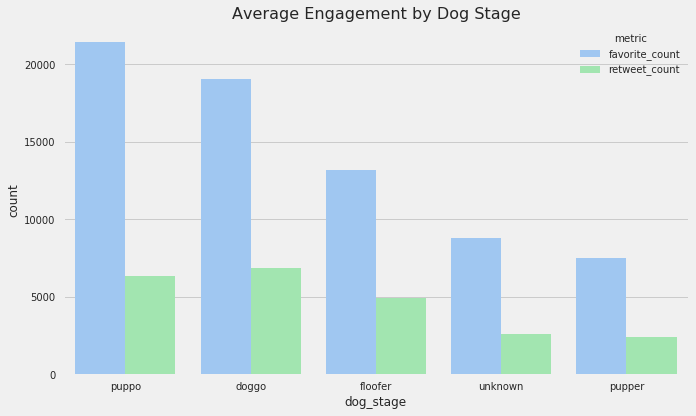

In [40]:
plt.figure(figsize=(10, 6))
melted = engagement.reset_index().melt(id_vars='dog_stage', 
                                      var_name='metric', 
                                      value_name='count')
sns.barplot(x='dog_stage', y='count', hue='metric', data=melted)
plt.title('Average Engagement by Dog Stage')
plt.savefig('engagement_by_stage.png')
plt.show()

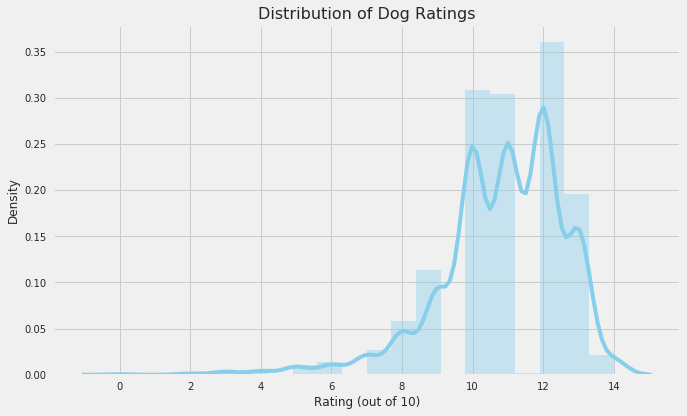

In [41]:
# Visualization 2: Rating Distribution
plt.figure(figsize=(10, 6))
sns.distplot(df['rating_numerator'].dropna(), bins=20, kde=True, color='skyblue')
plt.title('Distribution of Dog Ratings', fontsize=16)
plt.xlabel('Rating (out of 10)', fontsize=12)
plt.ylabel('Density', fontsize=12)  # Note y-axis label change
plt.savefig('rating_distribution.png', bbox_inches='tight')
plt.show()

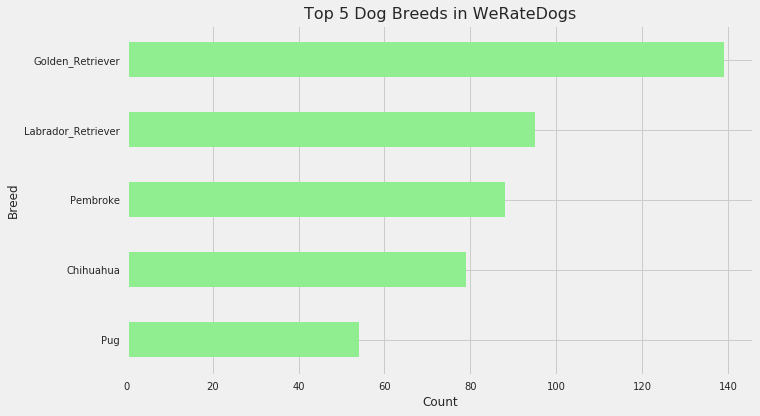


Visualizations saved:
- engagement_by_stage.png
- rating_distribution.png
- top_breeds.png


In [42]:
# Visualization 3: Top Breeds
plt.figure(figsize=(10, 6))
top_breeds_sorted = top_breeds.sort_values()
top_breeds_sorted.plot(kind='barh', color='lightgreen')
plt.title('Top 5 Dog Breeds in WeRateDogs', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Breed', fontsize=12)
plt.savefig('top_breeds.png', bbox_inches='tight')
plt.show()

print("\nVisualizations saved:")
print("- engagement_by_stage.png")
print("- rating_distribution.png")
print("- top_breeds.png")